
## Setup FastAI and timm

In [1]:

!pip install -U albumentations
!pip install opencv-python==4.5.4.60
!pip install -q --upgrade fastcore fastai
!pip install timm==0.6.2.dev0




In [2]:
import random # just as the name implies, it's used for randomness
import numpy as np #numpy is numpy.......manages arrays
import gc #This is the garbage collector, I doubt we'll use it. i'm using colab pro
from pathlib import Path #path library manages path
import matplotlib.pyplot as plt #to plot basically
import pandas as pd #key library to manage your dataframe.

import albumentations
import timm

import fastai
from fastai.vision.all import * #import everthing from vision
print(fastai.__version__ )

2.7.9


## Load the files

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
 path = '/content/drive/MyDrive/bollworm-weekendz/'

In [5]:
train_df = pd.read_csv(path + "Train.csv")
test_df = pd.read_csv(path + "Test.csv")
ss = pd.read_csv(path + "SampleSubmission.csv")


In [6]:
train_df.isnull().sum()

image_id    0
label       0
dtype: int64

In [7]:
# unzip the data file
!unzip '/content/drive/MyDrive/bollworm-weekendz/ModImages.zip'

## seed

In [8]:
#Seed everything for reproducibility
def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.

In [9]:
random_seed(2022,True)

In [10]:
train_df.head()

,image_id,label
0,id_006296f82479c03459102436.jpg,0
1,id_006e9f771965fd78278baa19.jpg,1
2,id_00750938fb12fad4fd8fad24.jpg,1
3,id_00773a42b1415d887107663a.jpg,1
4,id_00c6d6db61a9d7393ad39186.jpg,1


In [11]:

train_df["image_id"] = ["/content/content/ModImages/" + i for i in train_df["image_id"]]


In [12]:
train_df.head()

,image_id,label
0,/content/content/ModImages/id_006296f82479c03459102436.jpg,0
1,/content/content/ModImages/id_006e9f771965fd78278baa19.jpg,1
2,/content/content/ModImages/id_00750938fb12fad4fd8fad24.jpg,1
3,/content/content/ModImages/id_00773a42b1415d887107663a.jpg,1
4,/content/content/ModImages/id_00c6d6db61a9d7393ad39186.jpg,1


In [13]:
#Not an imbalanced dataset phewks
train_df.label.value_counts()

1    1296
0     651
Name: label, dtype: int64


## Correct some wrong labels. - Didn't make use of it

In [14]:
issues = [
# ("/content/Images/ImageID_2OK3T60A.jpg", "Church"),
# ("/content/Images/ImageID_TSDTGVSP.jpg","Church"),

]



In [15]:
#Rename labels
for x,y in issues:
  train_df.loc[train_df['Image_id'] == x, 'label'] = y

In [16]:
#Track rubbish labels
train_df.loc[train_df['label'] == ""].index.values.tolist()

[]

In [17]:
#Drop them from the DataFrame.
train_df = train_df.drop(train_df.loc[train_df['label'] == ""].index.values.tolist(), axis = 0).reset_index(drop=True)

In [18]:
train_df.shape

(1947, 2)

In [19]:
#Check new label distribution since you've edited.
train_df.label.value_counts()

1    1296
0     651
Name: label, dtype: int64

In [20]:
#check the size of one image, it'll give you a sense of what you are about to resize
Image.open('/content/content/ModImages/id_005102f664b820f778291dee.jpg').size

(720, 540)

## Albumentations

In [21]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [22]:
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(384, 384), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            
            albumentations.Rotate(limit=(-90, 90)),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.RandomGamma(),
            # albumentations.RandomGridShuffle(p=0.5)
            ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(384, 384),
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

## DATABLOCK

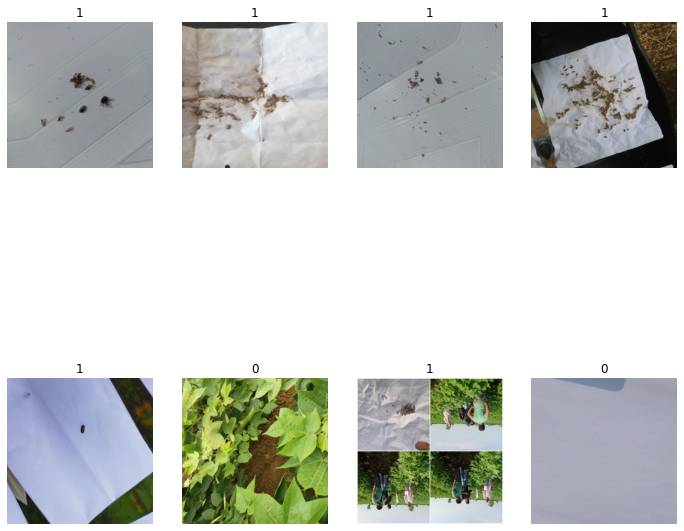

In [23]:

blocks = (ImageBlock, CategoryBlock)
splitter = TrainTestSplitter(0.1, stratify=train_df["label"])
block = DataBlock(blocks = blocks,
                 get_x=ColReader(0),
                 get_y=ColReader(1),
                 splitter = splitter,
                 item_tfms = item_tfms,
                 batch_tfms = batch_tfms)
dls = block.dataloaders(train_df, bs=8)
dls.show_batch(figsize=(12,12))

In [24]:
timm.list_models('vit*')

['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch14_224',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch

## MODEL 1:  vit_base_patch16_384

In [25]:
roc = RocAucBinary()
learn = vision_learner(dls,"vit_base_patch16_384", loss_func=CrossEntropyLossFlat(),metrics=[accuracy, error_rate, roc]) 
learn.to_fp16()

In [26]:
# del variables
gc.collect()

15268

SuggestedLRs(valley=0.0008317637839354575)

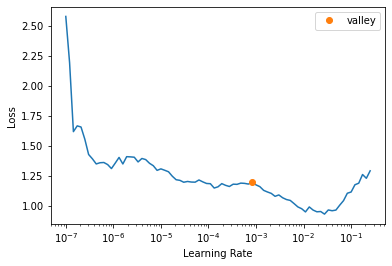

In [27]:
learn.lr_find()

In [28]:
learn.fine_tune(15,0.0008317637839354575, freeze_epochs=1,cbs=[GradientAccumulation(), SaveModelCallback()]) 

epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.717743,0.285393,0.871795,0.128205,0.947101,01:52


Better model found at epoch 0 with valid_loss value: 0.28539347648620605.


epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.608227,0.219401,0.882051,0.117949,0.974793,02:04
1,0.438847,0.185369,0.933333,0.066667,0.974556,02:03
2,0.429754,0.167295,0.933333,0.066667,0.982130,02:03
3,0.404046,0.197343,0.928205,0.071795,0.972071,02:03
4,0.315566,0.131995,0.953846,0.046154,0.987692,02:03
5,0.289896,0.141355,0.953846,0.046154,0.987456,02:03
6,0.273115,0.173241,0.953846,0.046154,0.968521,02:02
7,0.286247,0.122765,0.958974,0.041026,0.990414,02:03
8,0.232463,0.162651,0.943590,0.056410,0.988876,02:03
9,0.148178,0.119244,0.969231,0.030769,0.986864,02:03


Better model found at epoch 0 with valid_loss value: 0.21940085291862488.
Better model found at epoch 1 with valid_loss value: 0.18536865711212158.
Better model found at epoch 2 with valid_loss value: 0.16729548573493958.
Better model found at epoch 4 with valid_loss value: 0.13199535012245178.
Better model found at epoch 7 with valid_loss value: 0.12276509404182434.
Better model found at epoch 9 with valid_loss value: 0.11924402415752411.
Better model found at epoch 11 with valid_loss value: 0.10083774477243423.


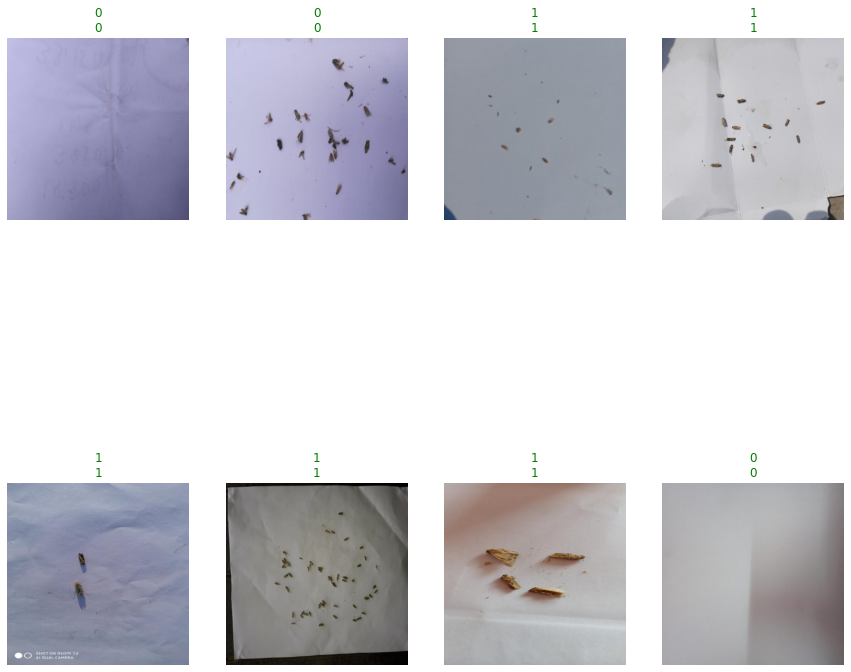

In [29]:
learn.show_results(figsize=(15,15))


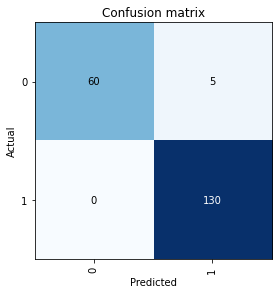

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [32]:
# interp.plot_top_losses(10,nrows=1)

In [33]:
learn.to_fp32()
learn.save(path + 'vit_base_patch16_384')

Path('/content/drive/MyDrive/bollworm-weekendz/vit_base_patch16_384.pth')

## Inference

In [34]:
sub = pd.read_csv(path + 'SampleSubmission.csv')


sample_df = sub.copy()



sample_df["image_id"] = ["/content/content/ModImages/" + i for i in sample_df["image_id"]]

sample_df.head()

,image_id,label
0,/content/content/ModImages/id_005102f664b820f778291dee.jpg,0
1,/content/content/ModImages/id_0066456f5fb2cd858c69ab39.jpg,0
2,/content/content/ModImages/id_007159c1fa015ba6f394deeb.jpg,0
3,/content/content/ModImages/id_00ba116c0f45a71a7e0e652c.jpg,0
4,/content/content/ModImages/id_00c11f7689e2351305cb12e3.jpg,0


In [36]:
test_dl = learn.dls.test_dl(sample_df)
preds, _ = learn.tta(dl=test_dl, n=15)
preds[:,1]
predictions = preds[:,1]
sample = test_df
sample.loc[:, "label"] = predictions
sample.to_csv(path + "vit_base_patch16_384_15.csv", index=False)
sample.head()

,image_id,label
0,id_005102f664b820f778291dee.jpg,0.994860
1,id_0066456f5fb2cd858c69ab39.jpg,0.997277
2,id_007159c1fa015ba6f394deeb.jpg,0.001211
3,id_00ba116c0f45a71a7e0e652c.jpg,0.018188
4,id_00c11f7689e2351305cb12e3.jpg,0.910117


In [ ]:
# del variables
gc.collect()
del learn